#Text classification using Neural Network

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [20]:
df = pd.read_csv("wine-reviews.csv", usecols = ['country', 'description', 'points', 'price', 'variety', 'winery'])
# csv like : https://drive.google.com/drive/folders/1YnxDqNIqM2Xr1Dlgv5pYsE6dYJ9MGxcM
df["label"]=(df["points"] >=90).astype(int)
df

,country,description,points,price,variety,winery,label
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia,0
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos,0
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm,0
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian,0
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks,0
...,...,...,...,...,...,...,...
129966,Germany,Notes of honeysuckle and cantaloupe sweeten th...,90,28.0,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef),1
129967,US,Citation is given as much as a decade of bottl...,90,75.0,Pinot Noir,Citation,1
129968,France,Well-drained gravel soil gives this wine its c...,90,30.0,Gewürztraminer,Domaine Gresser,1
129969,France,"A dry style of Pinot Gris, this is crisp with ...",90,32.0,Pinot Gris,Domaine Marcel Deiss,1


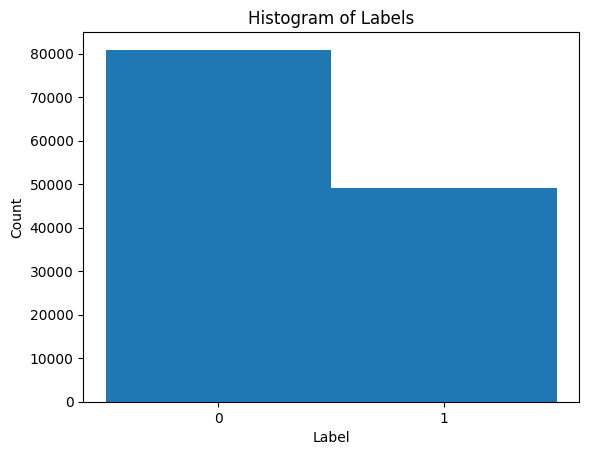

In [21]:
plt.hist(df["label"],bins=[-0.5,0.5,1.5])
plt.xticks([0, 1])
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Histogram of Labels")
plt.show()

In [22]:
X=df[["description"]]
y=df[["label"]]

In [23]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X,y=ros.fit_resample(X,y)

In [24]:
y["label"].value_counts()

,count
label,
0,80926
1,80926


In [25]:
X['description'].shape

(161852,)

In [26]:
y["label"].shape

(161852,)

In [27]:
df = pd.concat([X, y], axis=1)
df.head(2)

,description,label
0,"Aromas include tropical fruit, broom, brimston...",0
1,"This is ripe and fruity, a wine that is smooth...",0


In [28]:
train,temp = train_test_split(df,test_size=0.4,random_state=42)
valid,test = train_test_split(temp,test_size=0.4,random_state=42)

# Transforming into tf dataframe

In [29]:
def transform(dataframe,shuffle=True,batch_size=1024):
  df=dataframe.copy()
  label=df.pop("label")
  description=df["description"]
  ds=tf.data.Dataset.from_tensor_slices((description,label))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(df))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [30]:
train_data = transform(train)
valid_data = transform(valid)
test_data = transform(test)

In [31]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

#Embedding and model training

In [32]:
import tensorflow_hub as hub

embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(
    embedding,
    dtype=tf.string,
    trainable=True
)

In [33]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.51605034, -0.02789966,  0.33146784, ..., -0.10405941,
        -0.21875292,  0.00064533],
       [ 0.35362244, -0.18754189,  0.00952444, ..., -0.09428616,
        -0.28222206,  0.08394922],
       [ 0.38574955, -0.16670239,  0.16566609, ..., -0.01945738,
        -0.2811389 ,  0.04952083],
       ...,
       [ 0.18536484, -0.11709699, -0.00546994, ..., -0.2515571 ,
         0.01470914, -0.03578927],
       [ 0.18779552, -0.33252135,  0.1792074 , ..., -0.04154277,
        -0.12456028, -0.2496234 ],
       [ 0.40374964, -0.05631944, -0.05704535, ..., -0.00562587,
        -0.1421589 , -0.14457951]], dtype=float32)>

In [34]:
import tf_keras as keras # if not imported like this , it shows value error and you have to !pip install tf-keras
model = keras.Sequential()
model.add(hub_layer)
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(1,activation="sigmoid"))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [36]:
history = model.fit(train_data,epochs=5,batch_size=3035,validation_data=valid_data)

Epoch 1/5
95/95 [==============================] - 137s 1s/step - loss: 0.6433 - accuracy: 0.6226 - val_loss: 0.5125 - val_accuracy: 0.7766
Epoch 2/5
95/95 [==============================] - 116s 1s/step - loss: 0.4812 - accuracy: 0.7866 - val_loss: 0.4003 - val_accuracy: 0.8189
Epoch 3/5
95/95 [==============================] - 130s 1s/step - loss: 0.4038 - accuracy: 0.8315 - val_loss: 0.3760 - val_accuracy: 0.8303
Epoch 4/5
95/95 [==============================] - 118s 1s/step - loss: 0.3613 - accuracy: 0.8537 - val_loss: 0.3682 - val_accuracy: 0.8345
Epoch 5/5
95/95 [==============================] - 118s 1s/step - loss: 0.3329 - accuracy: 0.8672 - val_loss: 0.3679 - val_accuracy: 0.8369


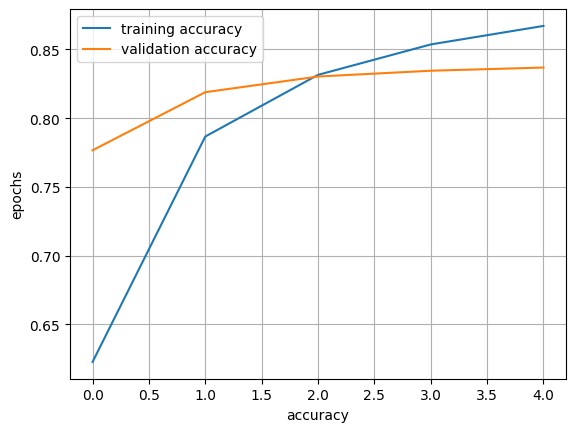

In [37]:
plt.plot(history.history["accuracy"],label="training accuracy")
plt.plot(history.history["val_accuracy"],label="validation accuracy")
plt.xlabel("accuracy")
plt.ylabel('epochs')
plt.legend()
plt.grid()
plt.show()

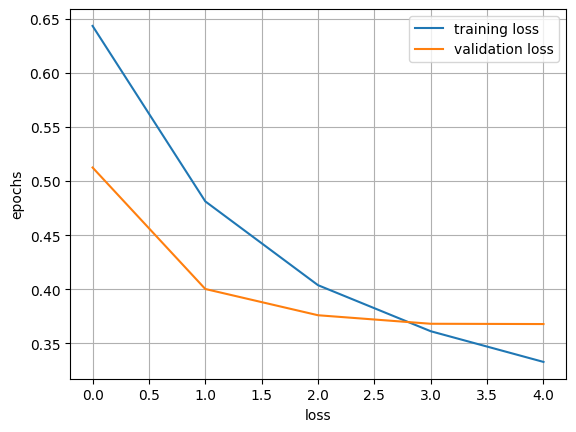

In [38]:
plt.plot(history.history["loss"],label="training loss")
plt.plot(history.history["val_loss"],label="validation loss")
plt.xlabel("loss")
plt.ylabel('epochs')
plt.legend()
plt.grid()
plt.show()

In [40]:
model.evaluate(test_data)

26/26 [==============================] - 7s 258ms/step - loss: 0.3664 - accuracy: 0.8365


[0.36639517545700073, 0.8365447521209717]

This accuracy was achieved after some hyperparameter tuning. While not fully optimised, it is satisfactory for our current purposes.

#LSTM using

In [41]:
encoder = tf.keras.layers.TextVectorization(max_tokens=1000)
encoder.adapt(train_data.map(lambda text,label:text))

In [43]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'in', 'flavors', 'it', 'to', 'its', 'fruit', 'on', 'aromas',
       'palate', 'that'], dtype='<U15')

In [44]:
import keras # this is fuctional, doesn't raise value error
model_lstm = keras.Sequential([
    encoder,
    keras.layers.Embedding(input_dim=len(vocab),output_dim=32,mask_zero=True),
    keras.layers.LSTM(32),
    keras.layers.Dense(32,activation = "relu"),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(1,activation="sigmoid")
])
model_lstm.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [45]:
history = model_lstm.fit(train_data,epochs=10,validation_data=valid_data)

Epoch 1/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 46s 418ms/step - accuracy: 0.6420 - loss: 0.6309 - val_accuracy: 0.8169 - val_loss: 0.4025
Epoch 2/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 51s 539ms/step - accuracy: 0.8183 - loss: 0.4074 - val_accuracy: 0.8261 - val_loss: 0.3803
Epoch 3/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 39s 409ms/step - accuracy: 0.8296 - loss: 0.3828 - val_accuracy: 0.8247 - val_loss: 0.3807
Epoch 4/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 42s 442ms/step - accuracy: 0.8295 - loss: 0.3785 - val_accuracy: 0.8259 - val_loss: 0.3782
Epoch 5/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 82s 443ms/step - accuracy: 0.8331 - loss: 0.3732 - val_accuracy: 0.8262 - val_loss: 0.3800
Epoch 6/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 40s 421ms/step - accuracy: 0.8334 - loss: 0.3687 - val_accuracy: 0.8276 - val_loss: 0.3744
Epoch 7/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 41s 434ms/step - accuracy: 0.8336 - loss: 0.3679 - val_accuracy: 0.8266 - val_loss: 0.3725
Epoch 8/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 41s 427ms/step - accuracy: 0.8372 - loss: 0.3604 - val_accu

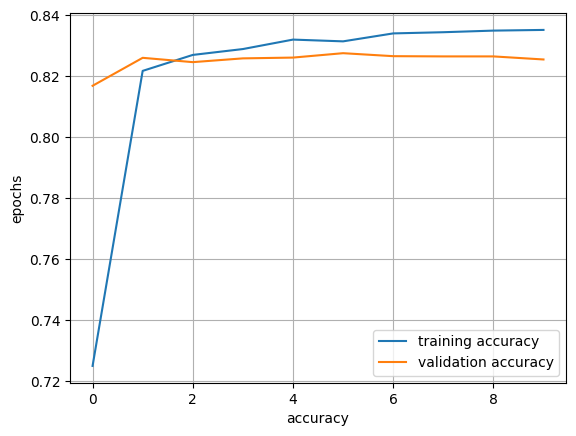

In [46]:
plt.plot(history.history["accuracy"],label="training accuracy")
plt.plot(history.history["val_accuracy"],label="validation accuracy")
plt.xlabel("accuracy")
plt.ylabel('epochs')
plt.legend()
plt.grid()
plt.show()

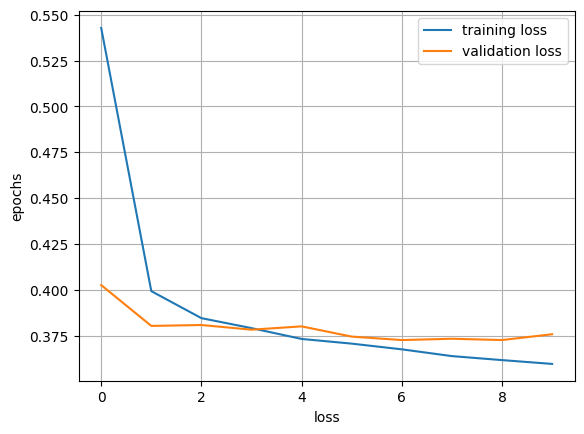

In [47]:
plt.plot(history.history["loss"],label="training loss")
plt.plot(history.history["val_loss"],label="validation loss")
plt.xlabel("loss")
plt.ylabel('epochs')
plt.legend()
plt.grid()
plt.show()

In [48]:
model.evaluate(test_data)

26/26 [==============================] - 4s 153ms/step - loss: 0.3664 - accuracy: 0.8365


[0.36639517545700073, 0.8365447521209717]

This accuracy was achieved after some hyperparameter tuning. While not fully optimised, it is satisfactory for our current purposes.